In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from pgmpy.estimators import MaximumLikelihoodEstimator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve
import numpy as np
from pgmpy.inference import VariableElimination  # Import VariableElimination from pgmpy.inference
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from sklearn.metrics import confusion_matrix
import seaborn as sns
from pgmpy.base import DAG

In [2]:
dataset_path = "diabetes_prediction_dataset.csv"
df = pd.read_csv(dataset_path)

# Fill the values missing in the data set 

In [3]:
#Filling missing categorical values with mode:
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().any():  # Check if there are missing values in the column
        df[col] = df[col].fillna(df[col].mode()[0])  # Fill missing values with mode

# Balancing the data based on the 'Diabetes' feature:


In [4]:
from sklearn.utils import resample

diabetes_df = df[df['diabetes'] == 1]
no_diabetes_df = df[df['diabetes'] == 0]

# Check if both groups have at least one sample
if len(diabetes_df) > 0 and len(no_diabetes_df) > 0:
    # Determine the smaller group
    if len(diabetes_df) < len(no_diabetes_df):
        smaller_group = diabetes_df
        larger_group = no_diabetes_df
    else:
        smaller_group = no_diabetes_df
        larger_group = diabetes_df
    
    # Upsample the smaller group to match the size of the larger group
    upsampled_smaller_group = resample(smaller_group, replace=True, n_samples=len(larger_group), random_state=42)
    
    # Combine the upsampled smaller group with the larger group
    balanced_df = pd.concat([upsampled_smaller_group, larger_group])
else:
    # If either group is empty, use the original dataset
    balanced_df = df

# Shuffle the data

In [5]:
#Shuffling the balanced dataset:
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Encode the data 

In [6]:
#Encoding categorical variables using label encoding:
label_encoder = LabelEncoder()
categorical_cols = balanced_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    balanced_df[col] = label_encoder.fit_transform(balanced_df[col])

#Saving the encoded and balanced dataset to a CSV file:
balanced_df.to_csv("encoded_balanced_dataset.csv", index=False)


# Split data into Training,Testing and validation

In [7]:
# Define the desired sizes for the reduced datasets
train_data = balanced_df[:50000]
val_data = balanced_df[50000:70000]
test_data = balanced_df[70000:150000]

train_data.to_csv("diabetes_train_dataset.csv", index=False)

# Display the shape of each dataset
print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Training data shape: (50000, 9)
Validation data shape: (20000, 9)
Test data shape: (80000, 9)


# Initialize the Bayesian network model

In [8]:
# Initialize BayesianModel
edges = [
    ('gender', 'diabetes'),
    ('age', 'diabetes'),
    ('age', 'hypertension'),
    ('age', 'heart_disease'),
    ('hypertension', 'diabetes'),
    ('hypertension', 'heart_disease'),
    ('heart_disease', 'diabetes'),
    ('smoking_history', 'diabetes'),
    ('smoking_history', 'hypertension'),
    ('smoking_history', 'heart_disease'),
    ('bmi', 'diabetes'),
    ('bmi', 'hypertension'),
    ('bmi', 'heart_disease'),
    ('HbA1c_level', 'diabetes'),
    ('HbA1c_level', 'blood_glucose_level'),
    ('blood_glucose_level', 'diabetes')
]

# Initialize DAG object with edges and train the model

In [9]:
# Get the variables in the dataset
variables = train_data.columns.tolist()

# Create a Directed Acyclic Graph (DAG) with the same variables
start_dag = DAG()
start_dag.add_nodes_from(variables)

# Add edges from 'treatment' to all other variables except itself
for factor in variables:
    if factor != 'diabetes':
        start_dag.add_edge(factor,'diabetes' )

# Initialize HillClimbSearch object
hc = HillClimbSearch(train_data)

# Initialize BIC score
bic = BicScore(train_data)

# Perform Hill climb search for the best model structure
best_model_structure = hc.estimate(tabu_length=10, max_indegree=3, start_dag=start_dag, scoring_method=bic)

# Create the Bayesian model from the best structure
model = BayesianNetwork(best_model_structure.edges())

# Fit the model using the training data
model.fit(train_data, estimator=MaximumLikelihoodEstimator)

is_valid = model.check_model()
print("Is this a Bayesian Network?",is_valid)

# Check if CPDs are associated with all variables
print("CPDs associated with all variables:")
print(model.get_cpds())

  0%|          | 0/1000000 [00:00<?, ?it/s]

Is this a Bayesian Network? True
CPDs associated with all variables:
[<TabularCPD representing P(gender:3 | heart_disease:2) at 0x7f8d56df5450>, <TabularCPD representing P(diabetes:2 | gender:3, heart_disease:2) at 0x7f8d56df7fd0>, <TabularCPD representing P(smoking_history:6 | diabetes:2, gender:3, heart_disease:2) at 0x7f8d56df7430>, <TabularCPD representing P(heart_disease:2) at 0x7f8d56d51990>, <TabularCPD representing P(age:102 | diabetes:2, heart_disease:2) at 0x7f8d56d51930>, <TabularCPD representing P(hypertension:2 | diabetes:2, heart_disease:2, smoking_history:6) at 0x7f8d56d509d0>, <TabularCPD representing P(HbA1c_level:18 | diabetes:2) at 0x7f8d56d517b0>, <TabularCPD representing P(blood_glucose_level:18 | diabetes:2) at 0x7f8d56d51d50>]


# perform inference for diabetes prediction

In [10]:
inference = VariableElimination(model)

# Predict Model with evidence

In [11]:
import warnings

# Function to predict diabetes for a given dataset
def predict_diabetes(data):
    y_pred = []
    for _, row in data.iterrows():
        evidence = row.drop(['diabetes', 'bmi']).to_dict()
        
        # Perform inference using VariableElimination
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            query_result = inference.query(variables=['diabetes'], evidence=evidence)
        
        # Extract the probability of having diabetes
        prob_diabetes = query_result.values[1]
        
        # Compare the probability of diabetes with a threshold (e.g., 0.2)
        y_pred.append(prob_diabetes > 0.2)
    
    return y_pred

# Predict diabetes for the validation set
val_y_pred = predict_diabetes(val_data)
val_y_true = val_data['diabetes']

# Predict diabetes for the test set
test_y_pred = predict_diabetes(test_data)
test_y_true = test_data['diabetes']

# Predict Model without evidence

In [12]:
# Function to predict treatment outcome for a given dataset without evidence
def predict_treatment_outcome_no_evidence(data):
    y_pred = []
    for _, row in data.iterrows():
        # Perform inference using VariableElimination without evidence
        query_result = inference.query(variables=['diabetes'])
        # Extract the probability of the positive class (treatment)
        prob_treatment = query_result.values[1]
        # Compare the probability of treatment with a threshold (e.g., 0.5)
        y_pred.append(prob_treatment > 0.2)
    return y_pred

# Predict treatment outcome for the validation set without evidence
val_y_pred_no_evidence = predict_treatment_outcome_no_evidence(val_data)

# Predict treatment outcome for the test set without evidence
test_y_pred_no_evidence = predict_treatment_outcome_no_evidence(test_data)


# Model with Evidence vs Model without Evidence

In [13]:
from sklearn.metrics import confusion_matrix

# Function to compare predictions with and without evidence and visualize the results
def compare_predictions(true_labels, pred_labels_with_evidence, pred_labels_no_evidence):
    correct_with_evidence = sum(true_labels == pred_labels_with_evidence)
    correct_no_evidence = sum(true_labels == pred_labels_no_evidence)
    total_samples = len(true_labels)
    accuracy_with_evidence = correct_with_evidence / total_samples
    accuracy_without_evidence = correct_no_evidence / total_samples

    # Visualize the comparison
    labels = ['With Evidence', 'Without Evidence']
    accuracies = [accuracy_with_evidence, accuracy_without_evidence]
    plt.bar(labels, accuracies, color=['blue', 'red'])
    plt.xlabel('Prediction Method')
    plt.ylabel('Accuracy')
    plt.title('Comparison of Prediction Methods')
    plt.ylim(0, 1)
    plt.show()

    print("Accuracy with evidence:", correct_with_evidence / total_samples)
    print("Accuracy without evidence:", correct_no_evidence / total_samples)

    # Visualize the comparison
    labels = ['With Evidence', 'Without Evidence']
    correct_predictions = [correct_with_evidence, correct_no_evidence]
    plt.bar(labels, correct_predictions, color=['blue', 'red'])
    plt.xlabel('Prediction Method')
    plt.ylabel('Correct Predictions')
    plt.title('Comparison of Correct Predictions')
    plt.show()

    print("Correct predictions with evidence:", correct_with_evidence)
    print("Correct predictions without evidence:", correct_no_evidence)

    # Compute confusion matrices
    cm_with_evidence = confusion_matrix(true_labels, pred_labels_with_evidence)
    cm_no_evidence = confusion_matrix(true_labels, pred_labels_no_evidence)

    print("Confusion Matrix with Evidence:")
    print(cm_with_evidence)

    print("Confusion Matrix without Evidence:")
    print(cm_no_evidence)

# Compare predictions for validation set

Validation Set Comparison:


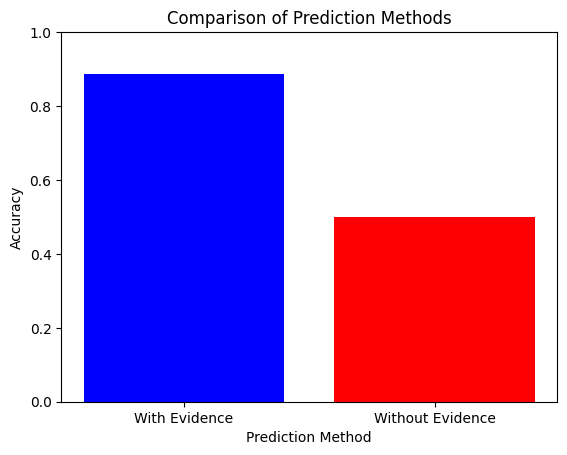

Accuracy with evidence: 0.8862
Accuracy without evidence: 0.4991


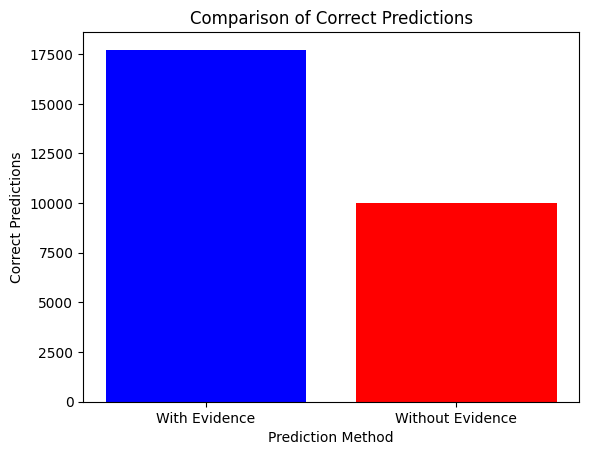

Correct predictions with evidence: 17724
Correct predictions without evidence: 9982
Confusion Matrix with Evidence:
[[7919 2099]
 [ 177 9805]]
Confusion Matrix without Evidence:
[[    0 10018]
 [    0  9982]]


In [14]:
# Compare predictions for the validation set
print("Validation Set Comparison:")
compare_predictions(val_y_true, val_y_pred, val_y_pred_no_evidence)

# Compare predictions for test set

Test Set Comparison:


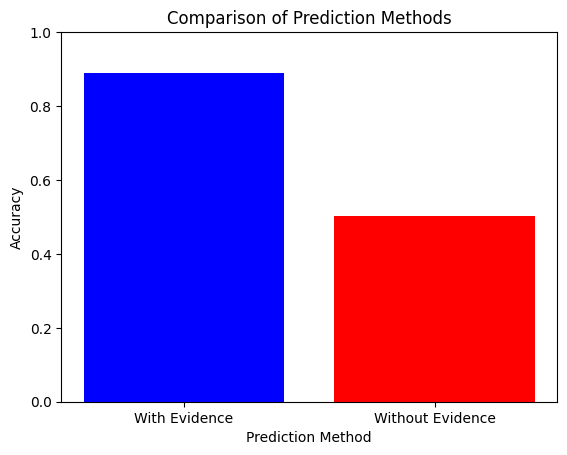

Accuracy with evidence: 0.888625
Accuracy without evidence: 0.501975


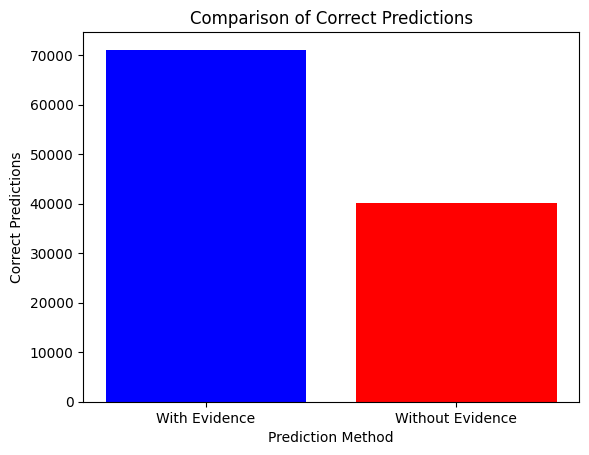

Correct predictions with evidence: 71090
Correct predictions without evidence: 40158
Confusion Matrix with Evidence:
[[31606  8236]
 [  674 39484]]
Confusion Matrix without Evidence:
[[    0 39842]
 [    0 40158]]


In [15]:
print("Test Set Comparison:")
compare_predictions(test_y_true, test_y_pred, test_y_pred_no_evidence)

# Compare evaluation metrics for both models

# Calculate evaluation metrics

In [16]:
# Function to calculate evaluation metrics
def calculate_evaluation_metrics(true_labels, pred_labels):
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    roc_auc = roc_auc_score(true_labels, pred_labels)
    return precision, recall, f1, roc_auc

# Function to compare evaluation metrics with and without evidence and visualize the results
def compare_evaluation_metrics(test_metrics_with_evidence, test_metrics_no_evidence):
    metrics = ['Precision', 'Recall', 'F1-score', 'ROC AUC']
    test_with_evidence = [test_metrics_with_evidence[0], test_metrics_with_evidence[1], test_metrics_with_evidence[2], test_metrics_with_evidence[3]]
    test_no_evidence = [test_metrics_no_evidence[0], test_metrics_no_evidence[1], test_metrics_no_evidence[2], test_metrics_no_evidence[3]]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots()
    # Set color to blue for "Test (With Evidence)"
    rects3 = ax.bar(x - width/2, test_with_evidence, width, color='blue', label='Test (With Evidence)')

    # Set color to red for "Test (Without Evidence)"
    rects4 = ax.bar(x + width/2, test_no_evidence, width, color='red', label='Test (Without Evidence)')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Evaluation Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    plt.show()
# Function to compare evaluation metrics with and without evidence and visualize the results
def compare_evaluation_metrics_val(val_metrics_with_evidence, val_metrics_no_evidence):
    metrics = ['Precision', 'Recall', 'F1-score', 'ROC AUC']
    val_with_evidence = [val_metrics_with_evidence[0], val_metrics_with_evidence[1], val_metrics_with_evidence[2], val_metrics_with_evidence[3]]
    val_no_evidence = [val_metrics_no_evidence[0], val_metrics_no_evidence[1], val_metrics_no_evidence[2], val_metrics_no_evidence[3]]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, val_with_evidence, width,color='blue', label='Validation (With Evidence)')
    rects2 = ax.bar(x + width/2, val_no_evidence, width,color='red', label='Validation (Without Evidence)')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Evaluation Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    plt.show()

# Calculate evaluation metrics for the validation set with and without evidence
val_metrics_with_evidence = calculate_evaluation_metrics(val_y_true, val_y_pred)
val_metrics_no_evidence = calculate_evaluation_metrics(val_y_true, val_y_pred_no_evidence)

# Calculate evaluation metrics for the test set with and without evidence
test_metrics_with_evidence = calculate_evaluation_metrics(test_y_true, test_y_pred)
test_metrics_no_evidence = calculate_evaluation_metrics(test_y_true, test_y_pred_no_evidence)

print("Validation Set Metrics with Evidence:")
print("Precision: {:.4f}".format(val_metrics_with_evidence[0]))
print("Recall: {:.4f}".format(val_metrics_with_evidence[1]))
print("F1-score: {:.4f}".format(val_metrics_with_evidence[2]))
print("ROC AUC: {:.4f}".format(val_metrics_with_evidence[3]))

print("\nValidation Set Metrics without Evidence:")
print("Precision: {:.4f}".format(val_metrics_no_evidence[0]))
print("Recall: {:.4f}".format(val_metrics_no_evidence[1]))
print("F1-score: {:.4f}".format(val_metrics_no_evidence[2]))
print("ROC AUC: {:.4f}".format(val_metrics_no_evidence[3]))

print("\nTest Set Metrics with Evidence:")
print("Precision: {:.4f}".format(test_metrics_with_evidence[0]))
print("Recall: {:.4f}".format(test_metrics_with_evidence[1]))
print("F1-score: {:.4f}".format(test_metrics_with_evidence[2]))
print("ROC AUC: {:.4f}".format(test_metrics_with_evidence[3]))

print("\nTest Set Metrics without Evidence:")
print("Precision: {:.4f}".format(test_metrics_no_evidence[0]))
print("Recall: {:.4f}".format(test_metrics_no_evidence[1]))
print("F1-score: {:.4f}".format(test_metrics_no_evidence[2]))
print("ROC AUC: {:.4f}".format(test_metrics_no_evidence[3]))

print("\nValidation Set Confusion Matrix with Evidence:")
print(confusion_matrix(val_y_true, val_y_pred))

print("\nValidation Set Confusion Matrix without Evidence:")
print(confusion_matrix(val_y_true, val_y_pred_no_evidence))

print("\nTest Set Confusion Matrix with Evidence:")
print(confusion_matrix(test_y_true, test_y_pred))

print("\nTest Set Confusion Matrix without Evidence:")
print(confusion_matrix(test_y_true, test_y_pred_no_evidence))

from sklearn.metrics import classification_report

print("\nValidation Set Classification Report with Evidence:")
print(classification_report(val_y_true, val_y_pred))

print("\nValidation Set Classification Report without Evidence:")
print(classification_report(val_y_true, val_y_pred_no_evidence))

print("\nTest Set Classification Report with Evidence:")
print(classification_report(test_y_true, test_y_pred))

print("\nTest Set Classification Report without Evidence:")
print(classification_report(test_y_true, test_y_pred_no_evidence))

Validation Set Metrics with Evidence:
Precision: 0.8237
Recall: 0.9823
F1-score: 0.8960
ROC AUC: 0.8864

Validation Set Metrics without Evidence:
Precision: 0.4991
Recall: 1.0000
F1-score: 0.6659
ROC AUC: 0.5000

Test Set Metrics with Evidence:
Precision: 0.8274
Recall: 0.9832
F1-score: 0.8986
ROC AUC: 0.8882

Test Set Metrics without Evidence:
Precision: 0.5020
Recall: 1.0000
F1-score: 0.6684
ROC AUC: 0.5000

Validation Set Confusion Matrix with Evidence:
[[7919 2099]
 [ 177 9805]]

Validation Set Confusion Matrix without Evidence:
[[    0 10018]
 [    0  9982]]

Test Set Confusion Matrix with Evidence:
[[31606  8236]
 [  674 39484]]

Test Set Confusion Matrix without Evidence:
[[    0 39842]
 [    0 40158]]

Validation Set Classification Report with Evidence:
              precision    recall  f1-score   support

           0       0.98      0.79      0.87     10018
           1       0.82      0.98      0.90      9982

    accuracy                           0.89     20000
   macro a

/home/rayhaan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rayhaan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rayhaan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rayhaan/.loca

# Test data with and without evidence

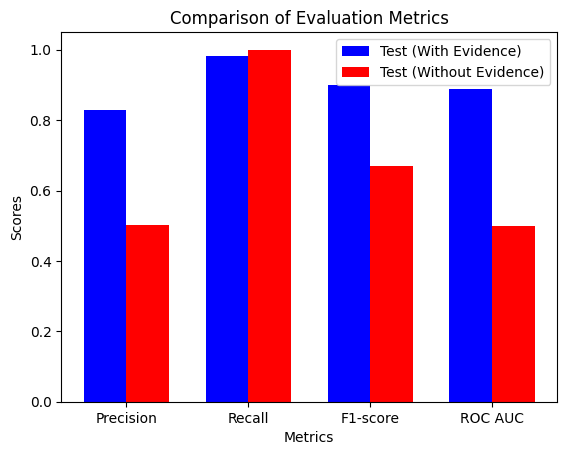

In [17]:
compare_evaluation_metrics(test_metrics_with_evidence, test_metrics_no_evidence)

# Validation data comparison with and without evidence

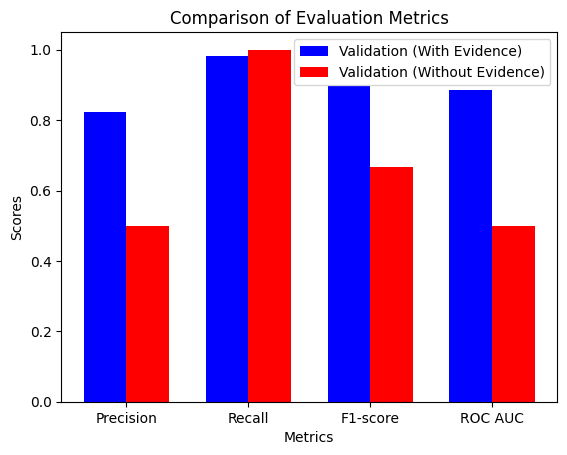

In [18]:
# Compare evaluation metrics and visualize the comparison
compare_evaluation_metrics_val(val_metrics_with_evidence, val_metrics_no_evidence)

# Visualize Bayesian Network Diagram

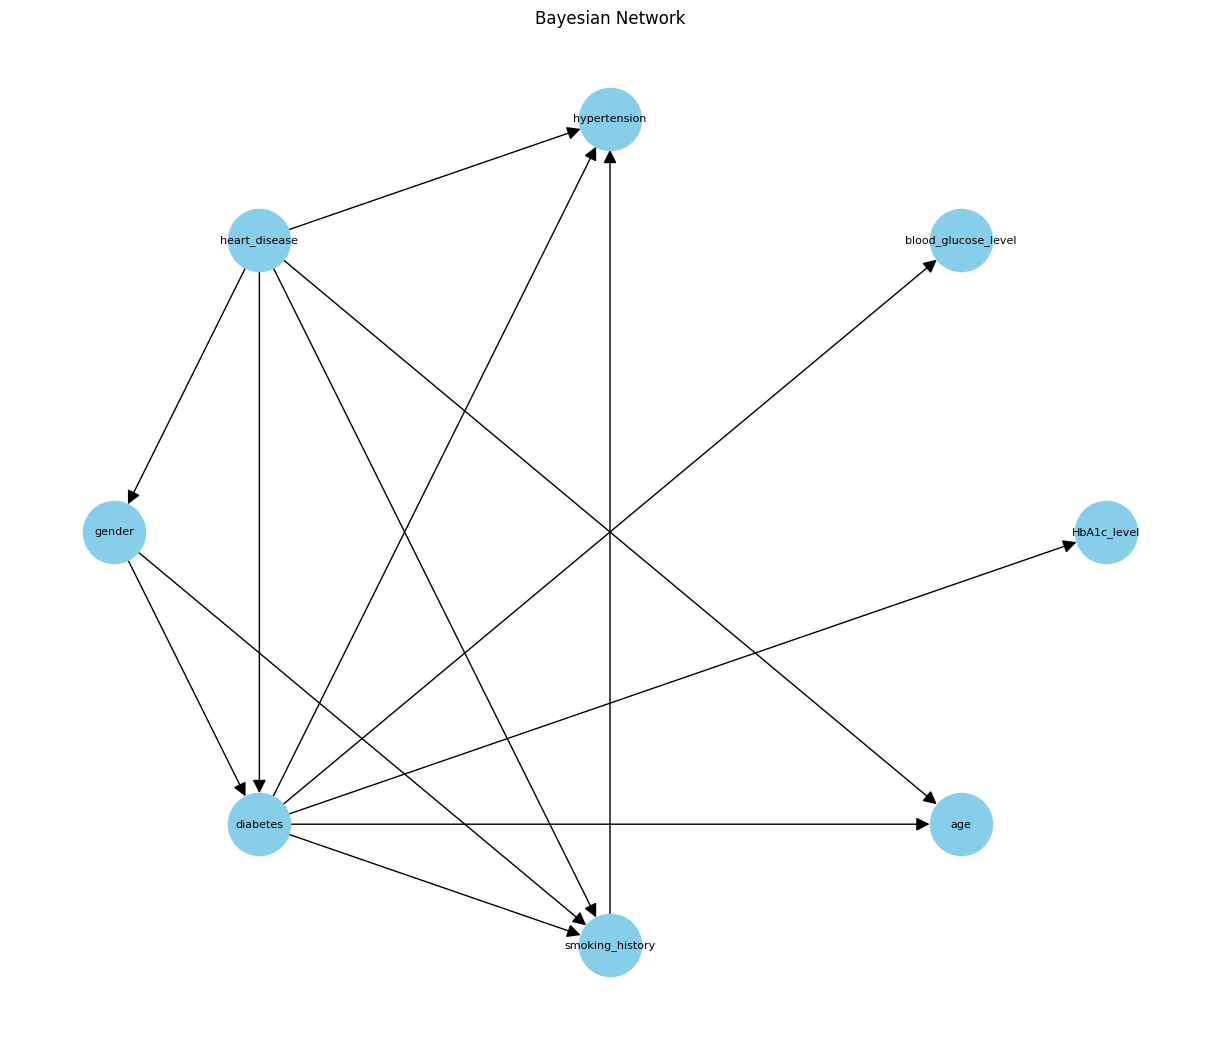

In [19]:
# Define the Bayesian network structure with V-structure and additional edges
# Visualize the Bayesian Network structure using networkx
G = nx.DiGraph(model.edges())
plt.figure(figsize=(12, 10))
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=8, arrowsize=20)
plt.title("Bayesian Network")
plt.show()

# Confusion Matrix

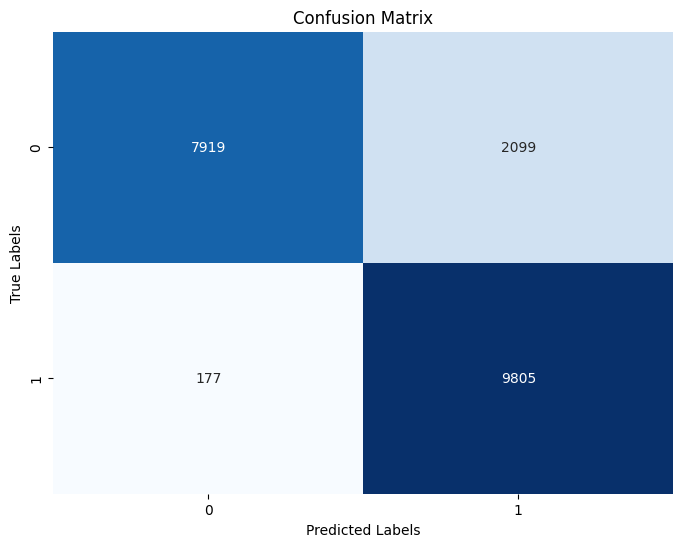

In [20]:
# Define true labels and predicted labels
true_labels = val_y_true  # Replace with your true labels
predicted_labels = val_y_pred  # Replace with your predicted labels

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Correlation matrix

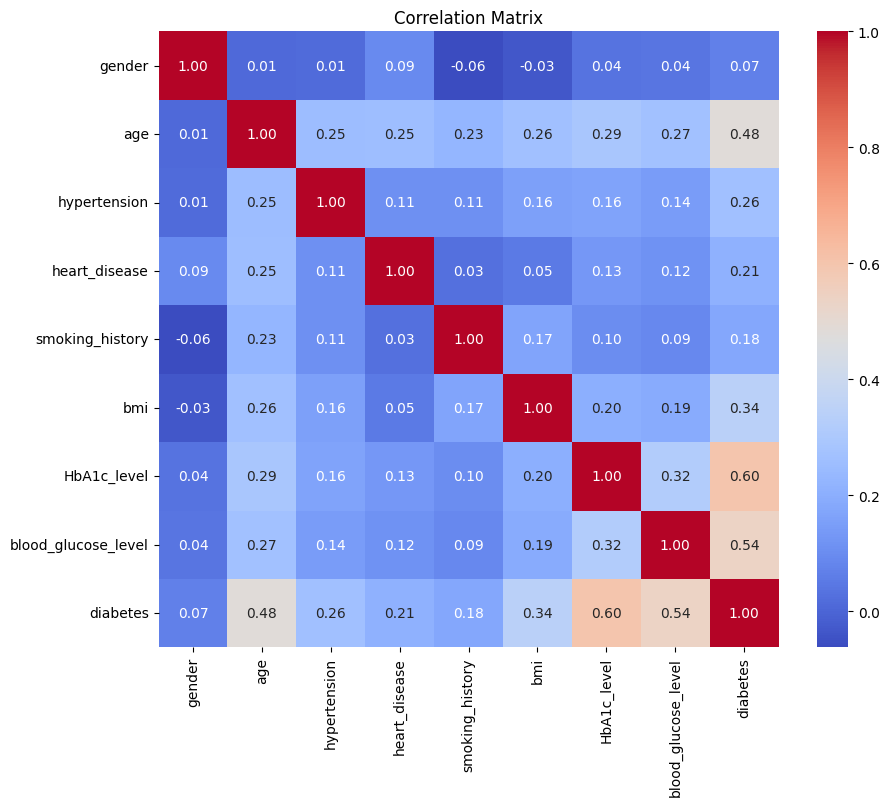

In [21]:


# Compute the correlation matrix
correlation_matrix = balanced_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()
